In [1]:
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D # Required for projection='3d'
import numpy as np

import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False

def visualize_lut(lut_image_path):
    """
    Loads a LUT image and visualizes it in several ways:
    1. As a 2D image strip.
    2. Input color space (identity cube) as a 3D scatter plot.
    3. Output color space (transformed by LUT) as a 3D scatter plot.
    4. Output color space as a 3D wireframe + scatter plot.
    """
    try:
        img = Image.open(lut_image_path)
        # Normalize image data to [0, 1]
        original_image_data = np.array(img) / 255.0
    except FileNotFoundError:
        print(f"错误：在路径 {lut_image_path} 未找到 LUT 图像文件。")
        return
    except Exception as e:
        print(f"加载图像时出错：{e}")
        return

    if original_image_data.ndim != 3 or original_image_data.shape[2] not in [3, 4]: # Allow RGB or RGBA
        print("错误：图像不是有效的 RGB/RGBA 图像。")
        return

    if original_image_data.shape[2] == 4: # If RGBA, take RGB
        print("检测到 RGBA 图像，将使用 RGB 通道。")
        original_image_data = original_image_data[:, :, :3]


    H, W, C = original_image_data.shape

    # Try to infer LUT size N, assuming common format: H=N, W=N*N
    # e.g., 16x256 (N=16), 32x1024 (N=32), 64x4096 (N=64)
    N = H
    if N <= 1 or W != N * N: # N must be at least 2 for a 3D LUT
        print(f"LUT 图像尺寸 ({H}x{W}) 不符合预期的 N 行 x N*N 列格式。")
        print("例如：16x256 (N=16), 32x1024 (N=32)。")
        print("将仅尝试将图像显示为2D条状图。")

        fig, ax = plt.subplots(1, 1, figsize=(8, max(1, H / W * 8) if W > 0 else 8))
        ax.imshow(original_image_data)
        ax.set_title(f"LUT 图像 ({H}x{W}) - 未能解析为3D LUT")
        ax.axis('off')
        plt.tight_layout()
        plt.show()
        return

    print(f"已解析 LUT 维度 N={N} (来自图像高度 {H})。图像宽度 {W} = {N}*{N}。")

    # 将2D图像数据重塑/重新映射为3D LUT数组 (R, G, B 索引)
    # original_image_data 格式为 (N_b, N_g*N_r, 3)
    # N_b = N (图像行, B 维度)
    # N_g*N_r = N*N (图像列)
    # 在图像列中：G 方向的块，每个块内 R 方向变化最快
    # lut_3d[r_idx, g_idx, b_idx, :] = original_image_data[b_idx, g_idx * N + r_idx, :]

    lut_3d = np.zeros((N, N, N, 3))
    for r_idx in range(N):
        for g_idx in range(N):
            for b_idx in range(N):
                img_col_idx = g_idx * N + r_idx # R 变化最快, 然后是 G 块
                img_row_idx = b_idx             # B 是行索引
                lut_3d[r_idx, g_idx, b_idx, :] = original_image_data[img_row_idx, img_col_idx, :]

    # 创建包含子图的图形窗口
    fig = plt.figure(figsize=(12, 10))
    fig.suptitle(f"LUT 可视化: {lut_image_path.split('/')[-1]} (N={N})", fontsize=16)

    # 图1: 原始 LUT 图像 (2D 条状图)
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.imshow(original_image_data)
    ax1.set_title(f"LUT 图像条 ({H}x{W})")
    ax1.axis('off')

    # --- 3D 图的数据准备 ---
    # 输入坐标 (归一化)
    r_in_norm = np.linspace(0, 1, N)
    g_in_norm = np.linspace(0, 1, N)
    b_in_norm = np.linspace(0, 1, N)
    # 创建网格点，R变化最快，然后G，然后B，匹配lut_3d的(R,G,B)索引
    R_in_grid, G_in_grid, B_in_grid = np.meshgrid(r_in_norm, g_in_norm, b_in_norm, indexing='ij')

    # 展平以便绘制散点图
    r_flat_in = R_in_grid.flatten()
    g_flat_in = G_in_grid.flatten()
    b_flat_in = B_in_grid.flatten()
    input_colors_for_plot = np.stack((r_flat_in, g_flat_in, b_flat_in), axis=-1)

    # 从 LUT 中获取输出颜色
    # lut_3d 的形状是 (N,N,N,3)。将其展平为 (N*N*N, 3)
    output_colors_flat = lut_3d.reshape(-1, 3)

    # 检查 NaN 或 Inf 值，它们可能导致散点图颜色问题
    if np.any(np.isnan(output_colors_flat)) or np.any(np.isinf(output_colors_flat)):
        print("警告：LUT 数据中发现 NaN 或 Inf。将值限制在 [0,1] 范围内。")
        output_colors_flat = np.nan_to_num(output_colors_flat, nan=0.0, posinf=1.0, neginf=0.0)
    output_colors_flat = np.clip(output_colors_flat, 0, 1) # 确保颜色值在[0,1]


    # 图2: 输入颜色立方体 (单位 LUT 可视化)
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    ax2.scatter(r_flat_in, g_flat_in, b_flat_in, c=input_colors_for_plot, s=15, depthshade=True)
    ax2.set_title("输入颜色空间 (单位立方体)")
    ax2.set_xlabel("R_in"); ax2.set_ylabel("G_in"); ax2.set_zlabel("B_in")
    ax2.set_xlim([0, 1]); ax2.set_ylim([0, 1]); ax2.set_zlim([0, 1])
    ax2.view_init(elev=20, azim=30) # 设置视角

    # 图3: 输出颜色立方体 (经 LUT 变换后) - 散点图
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    ax3.scatter(output_colors_flat[:, 0], output_colors_flat[:, 1], output_colors_flat[:, 2],
                c=output_colors_flat, s=15, depthshade=True)
    ax3.set_title("输出颜色空间 (LUT 变换后)")
    ax3.set_xlabel("R_out"); ax3.set_ylabel("G_out"); ax3.set_zlabel("B_out")
    # 根据数据动态设置坐标轴范围，但至少包含 [0,1]
    ax3.set_xlim([min(0, output_colors_flat[:,0].min()-0.05), max(1, output_colors_flat[:,0].max()+0.05)])
    ax3.set_ylim([min(0, output_colors_flat[:,1].min()-0.05), max(1, output_colors_flat[:,1].max()+0.05)])
    ax3.set_zlim([min(0, output_colors_flat[:,2].min()-0.05), max(1, output_colors_flat[:,2].max()+0.05)])
    ax3.view_init(elev=20, azim=30)

    # 图4: 输出颜色立方体 (线框 + 点)
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    # lut_3d 的维度是 (R, G, B, Color_Channel)
    X_out = lut_3d[:,:,:,0] # R_out values
    Y_out = lut_3d[:,:,:,1] # G_out values
    Z_out = lut_3d[:,:,:,2] # B_out values

    line_alpha = 0.2
    line_width = 0.5
    # 绘制沿 R 轴的线 (G, B 固定)
    for i in range(N): # G 索引
        for j in range(N): # B 索引
            ax4.plot(X_out[:, i, j], Y_out[:, i, j], Z_out[:, i, j], color='gray', alpha=line_alpha, linewidth=line_width)
    # 绘制沿 G 轴的线 (R, B 固定)
    for i in range(N): # R 索引
        for j in range(N): # B 索引
            ax4.plot(X_out[i, :, j], Y_out[i, :, j], Z_out[i, :, j], color='gray', alpha=line_alpha, linewidth=line_width)
    # 绘制沿 B 轴的线 (R, G 固定)
    for i in range(N): # R 索引
        for j in range(N): # G 索引
            ax4.plot(X_out[i, j, :], Y_out[i, j, :], Z_out[i, j, :], color='gray', alpha=line_alpha, linewidth=line_width)

    # 叠加散点以便观察颜色
    ax4.scatter(output_colors_flat[:, 0], output_colors_flat[:, 1], output_colors_flat[:, 2],
                c=output_colors_flat, s=5, depthshade=False) # 点小一些，关闭深度阴影以显示真实颜色

    ax4.set_title("输出颜色空间 (线框 + 点)")
    ax4.set_xlabel("R_out"); ax4.set_ylabel("G_out"); ax4.set_zlabel("B_out")
    ax4.set_xlim([min(0, output_colors_flat[:,0].min()-0.05), max(1, output_colors_flat[:,0].max()+0.05)])
    ax4.set_ylim([min(0, output_colors_flat[:,1].min()-0.05), max(1, output_colors_flat[:,1].max()+0.05)])
    ax4.set_zlim([min(0, output_colors_flat[:,2].min()-0.05), max(1, output_colors_flat[:,2].max()+0.05)])
    ax4.view_init(elev=20, azim=30)

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # 调整布局以适应主标题
    plt.show()

已解析 LUT 维度 N=32 (来自图像高度 32)。图像宽度 1024 = 32*32。


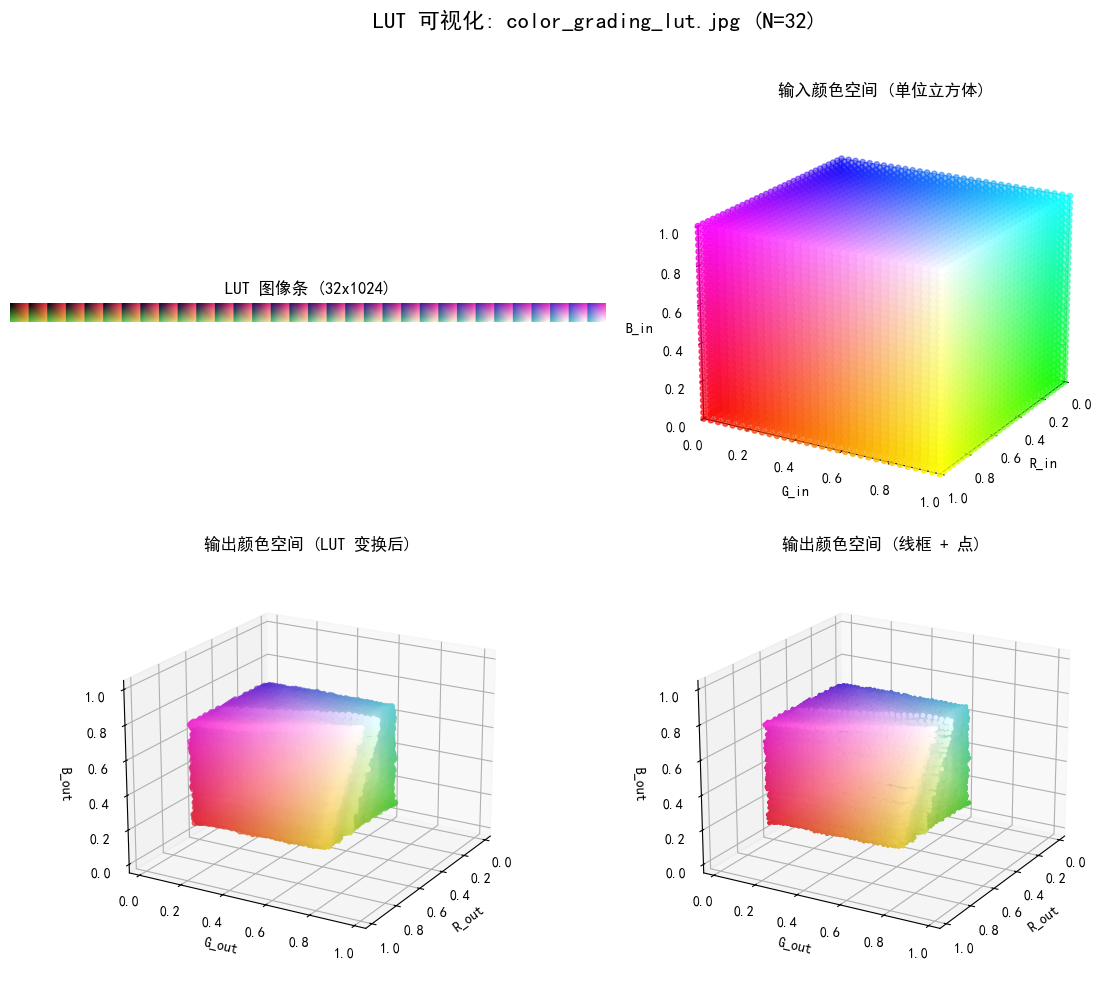

In [2]:
lut_file = "D:/documents/CG/Piccolo/engine/asset/texture/lut/color_grading_lut.jpg"

visualize_lut(lut_file)